# Init

In [1]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from pathlib import Path
import json

import matplotlib.colors as mcolors
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import cv2

%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [2]:
%autoreload 2
from src.MapData import MapData, min_max_dist, triangle_corr, get_triangular_kernel
from src.LineFinder import LineFinder

from src.plotting_functions import plot_embedding, plot_single_variable_map, _update_layout

# Data

In [3]:
map_data = MapData(
    'C:/Users/kepes/OneDrive - Vysoké učení technické v Brně/projects/P42B/2022_03_21_P42B_513x632.libsdata',
    overwrite=False
)
map_data.get_metadata()
map_data.load_wavelenths()
map_data.load_all_data('preprocessed')
map_data.get_map_dimensions()
map_data.trim_spectra(64)
map_data.estimate_systemic_noise()
map_data.get_baseline(
    min_window_size=50,
    smooth_window_size=100
)
map_data.baseline_correct()
map_data.upsample_spectra()
if map_data.systemic_noise_spectrum is not None:
    map_data.denoise_spectra(
        file_name_supplement='preprocessed',
        threshold=np.std(map_data.systemic_noise_spectrum)
    )
maxima_spectrum = map_data.spectra.max(axis=0)

loading metadata
loading wavelengths
getting map dimensions


In [4]:
line_finder = LineFinder(
    maxima_spectrum,
    map_data.wvl,
    name='maxima'
)
line_finder.find_lines()
line_finder.load_nist_tables(    
    Path('C:/Users/kepes/OneDrive - Vysoké učení technické v Brně/projects/marsData/inventory/nistTables')
)
line_finder.find_peaks_in_reference(
    maxima_spectrum, 
    scale=False,
    show_cond=False
)
line_finder.plot.show()

creating base plot


In [5]:
map_data.set_emission_line_parameters(
    line_finder.peaks[1].get('left_bases'),
    line_finder.peaks[1].get('right_bases'),
    line_centers=line_finder.peaks[0]
)
map_data.set_emisssion_line_functions(    
    intensity_funcs=[np.max,np.sum,min_max_dist,triangle_corr]
)
map_data.get_emission_line_intensities()

loading emission line intensities
converting line intensities to arrays


# Clustering

In [13]:
def plot_cluster_labels(
    plot_values: np.array,
    file_id: str = None,
    figure_title: str = None,
    colorbar_title: str = None,
    fig_size_scaling: float = 1.
):
    fig, ax = plt.subplots(
        1, 1,
        figsize=(
            3*fig_size_scaling,
            3*fig_size_scaling
        )
    )

    image = ax.imshow(
        plot_values,
        cmap='plasma',
        interpolation='bicubic',
        interpolation_stage='rgba',
        vmin=np.min(plot_values),
        vmax=np.max(plot_values)
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axes.set_alpha(0)

    bounds = np.unique(plot_values)
    norm = mcolors.BoundaryNorm(
        bounds, 
        len(bounds)
    )
    color_bar = fig.colorbar(
        image,
        boundaries=bounds, 
        ticks=bounds,        
        norm=norm
    )    
    if colorbar_title:
        color_bar.ax.set_title(colorbar_title)
    if figure_title:
        fig.suptitle(figure_title)

    fig.tight_layout()
    fig.show()

    if file_id:
        fig.savefig(
            f'./temp/{file_id}.png',
            transparent=True,
            dpi=300
        )

In [6]:
clustering_models = {
    'hdbscan': hdbscan.HDBSCAN(
        algorithm='best',
        approx_min_span_tree=True,
        gen_min_span_tree=False,
        leaf_size=15,
        metric='euclidean',
        min_cluster_size=10,
        min_samples=5,
        cluster_selection_epsilon=.2,
        p=None,
        core_dist_n_jobs=3
    ),
    'gmm': GaussianMixture(
        n_components=7,
        random_state=42
    ),
    'kmeans': KMeans(7)
}

cluster_labels = {}

c:\Users\kepes\Projects\segmentation\src\plotting_functions.py:192: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

<__array_function__ internals>:180: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



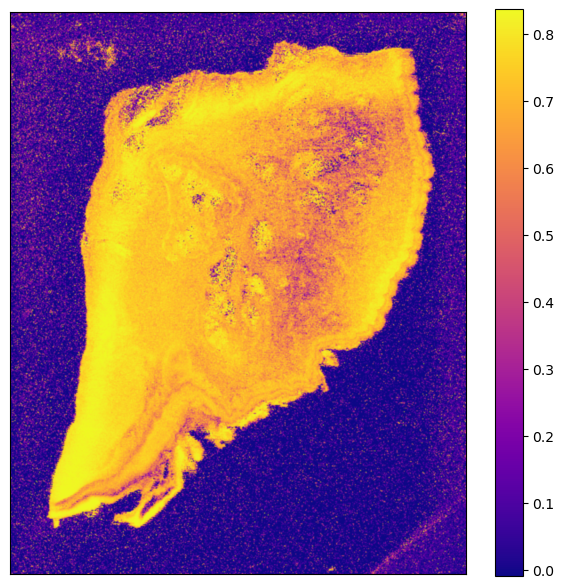

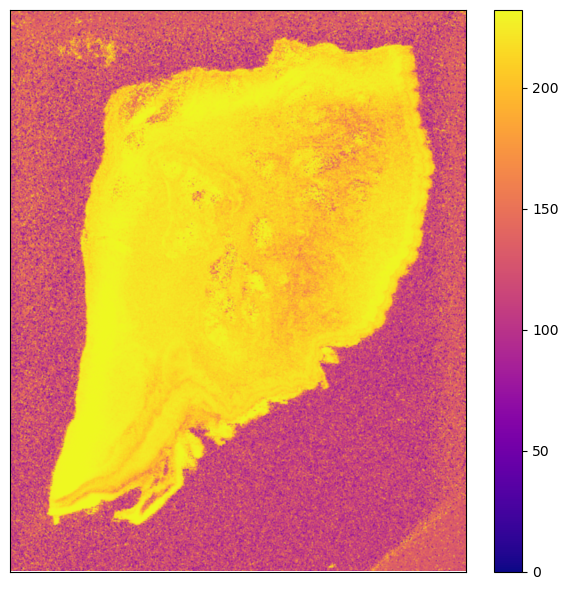

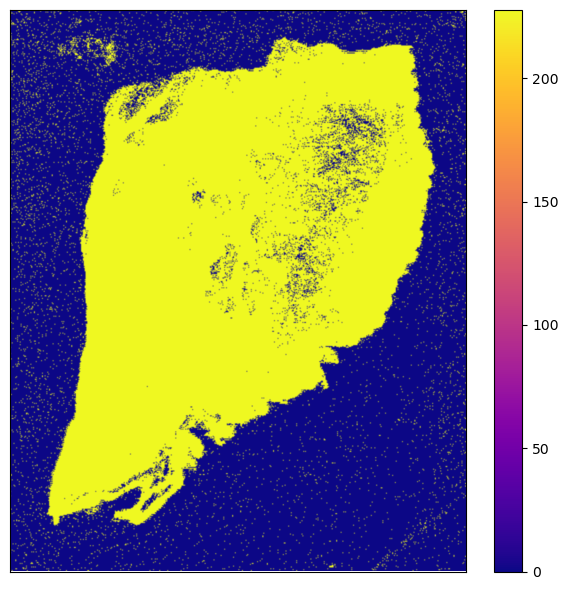

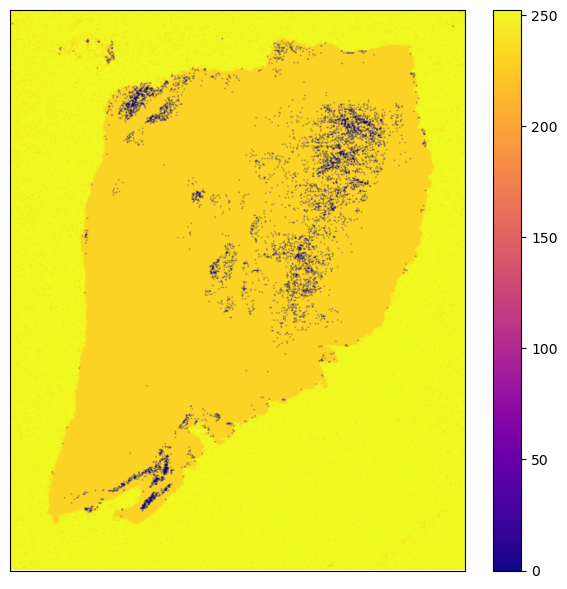

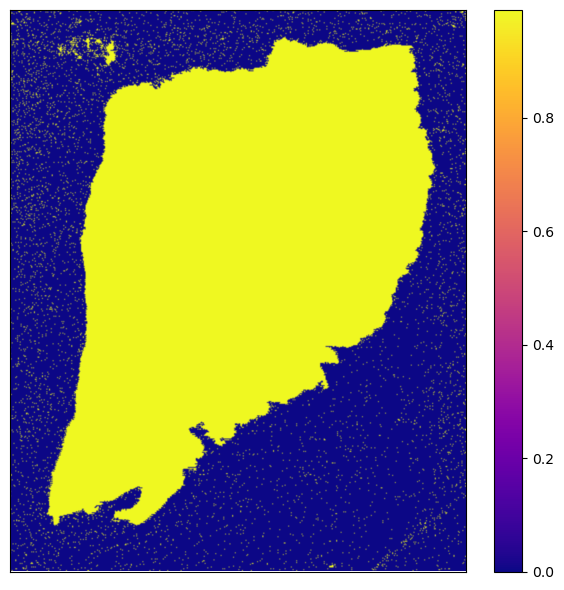

In [7]:
edge_data = map_data.vector_to_array(map_data.line_intensities['triangle_corr']['393.34'])
plot_single_variable_map(
    edge_data,
    fig_size_scaling=2
)

edge_data -= edge_data.min()
edge_data /= edge_data.max()
edge_data *= 255
edge_data = edge_data.astype(np.uint8)

plot_single_variable_map(
    edge_data,
    fig_size_scaling=2
)
th, im_th = cv2.threshold(
    edge_data, 
    180,
    230,
    cv2.THRESH_BINARY
)
plot_single_variable_map(
    im_th,
    fig_size_scaling=2    
)
im_floodfill = im_th.copy()
# im_floodfill = cv2.filter2D(
#     im_floodfill, 
#     -1, 
#     np.ones(shape=(7,7))/49
# )
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8) 
cv2.floodFill(im_floodfill, mask, (0,0), 255)

plot_single_variable_map(
    im_floodfill,
    fig_size_scaling=2    
)

background_mask = im_floodfill != 255
plot_single_variable_map(
    background_mask,
    fig_size_scaling=2    
)

background_mask[::2,:] = background_mask[::2,::-1]

In [8]:
cluster_labels

{}

In [9]:
func = 'sum'
for clustering_method in ['gmm','kmeans']:
# for clustering_method in clustering_models:
    for map_type in ['','_br']:
        if map_type == '':
            cluster_data = pd.DataFrame(map_data.line_intensities[func])
        elif map_type == '_br':
            cluster_data = pd.DataFrame(map_data.line_intensities[func]).loc[
                background_mask.reshape(-1),:
            ]
        cluster_data.replace(np.nan, 0, inplace=True)
        cluster_labels[f'{clustering_method}_{map_type}'] = clustering_models[clustering_method]\
            .fit_predict(cluster_data)

c:\Users\kepes\Projects\segmentation\pyenv_segment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\kepes\Projects\segmentation\pyenv_segment\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



C:\Users\kepes\AppData\Local\Temp\ipykernel_11748\3003210710.py:46: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



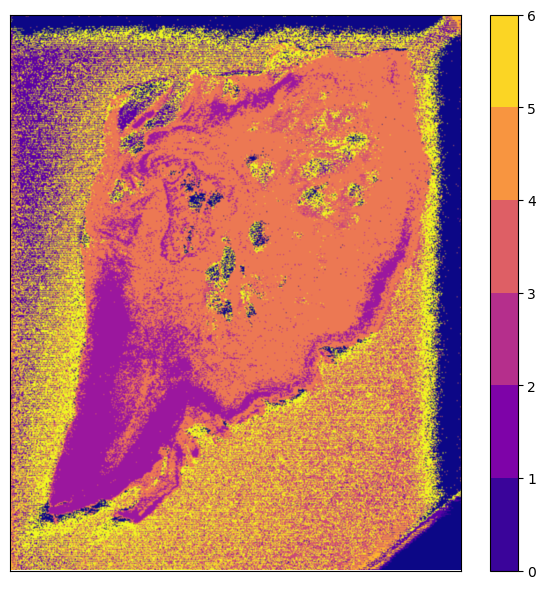

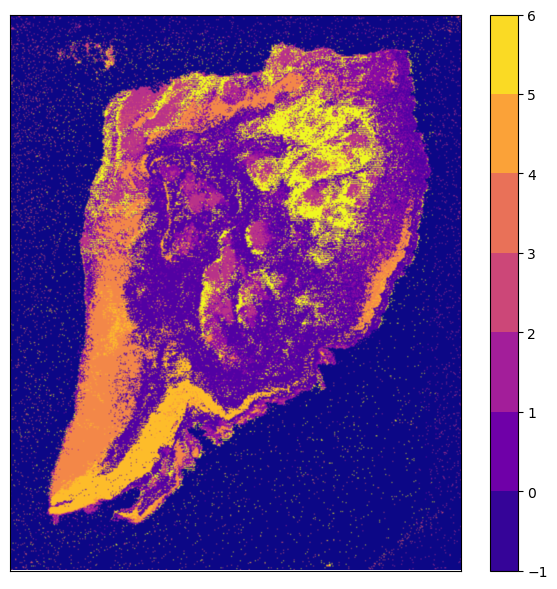

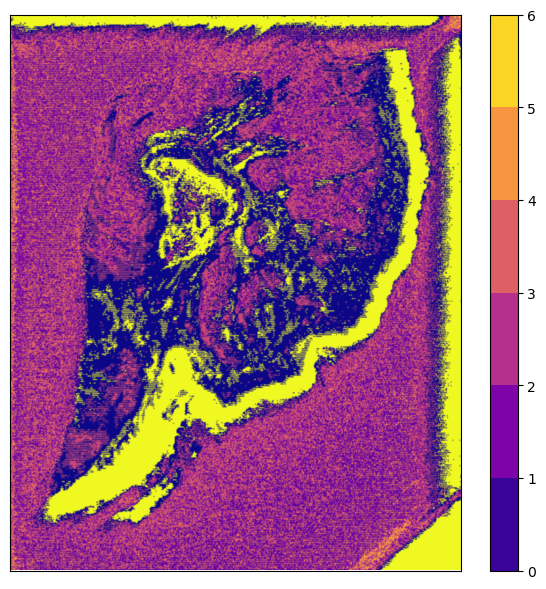

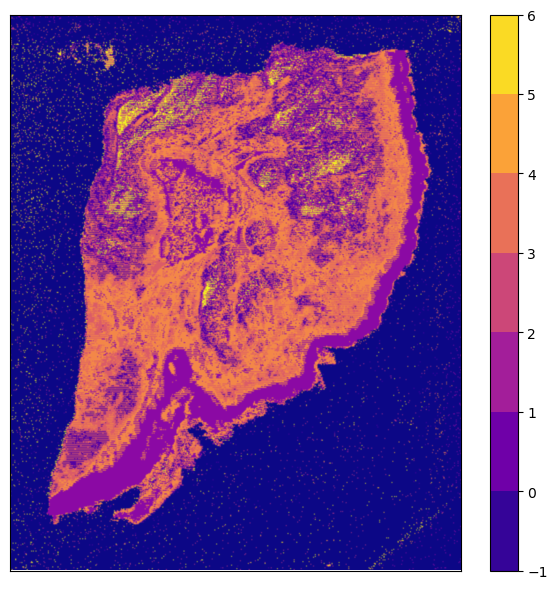

In [14]:
for cluster_method in cluster_labels:
    if '_br' in cluster_method:
        plot_data = np.zeros(map_data.spectra.shape[0]) - 1
        plot_data[background_mask.reshape(-1)] = cluster_labels[cluster_method]
    elif '_br' not in cluster_method:
        plot_data = cluster_labels[cluster_method]
    
    plot_cluster_labels(
        map_data.vector_to_array(plot_data),
        fig_size_scaling=2,
        file_id=f'clustering_{cluster_method}_from_lines_{func}',
    )

In [39]:
cluster_method = 'gmm_'

In [38]:
plot_data[background_mask.reshape(-1)][cluster_labels[cluster_method] == 3]

array([-1., -1., -1., ..., -1., -1., -1.])

C:\Users\kepes\AppData\Local\Temp\ipykernel_11748\3003210710.py:46: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



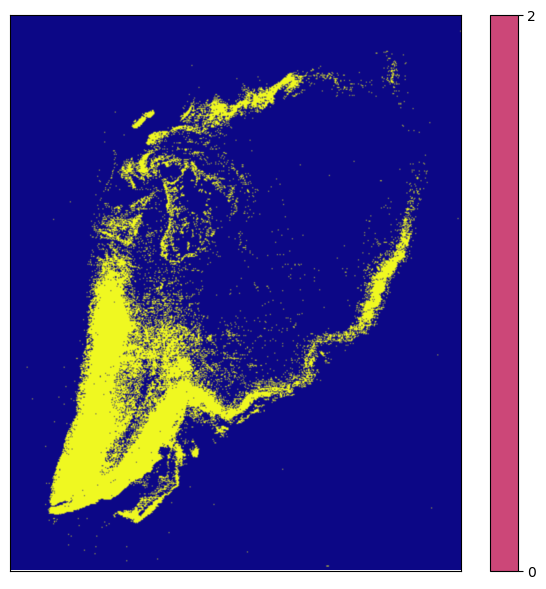

In [48]:
NDX = 2

plot_data = np.zeros(map_data.spectra.shape[0]) 
plot_data[cluster_labels[cluster_method] == NDX] = NDX
plot_cluster_labels(
        map_data.vector_to_array(plot_data),
        fig_size_scaling=2,
        file_id=f'clustering_{cluster_method}_from_lines_{func}_subset',
    )